In [0]:
import os
import cv2
import h5py
import numpy
from PIL import Image
import prepare_data as pd
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import adam
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation

In [12]:
#UPLOAD TRAINING DATASET
from google.colab import files
uploaded = files. upload()

Saving prepare_data.py to prepare_data.py


In [24]:
#UPLOAD TRAINING DATASET
from google.colab import files
uploaded = files. upload()

Saving yang91.zip to yang91.zip


In [51]:
#UPLOAD TRAINING DATASET
from google.colab import files
uploaded = files. upload()

Saving baby_GT.bmp to baby_GT.bmp


In [54]:
!ls

baby_GT.bmp  sample_data  yang91  yang91.zip


In [25]:
!unzip yang91.zip 

Archive:  yang91.zip
   creating: yang91/
  inflating: yang91/tt9.bmp          
  inflating: yang91/tt8.bmp          
  inflating: yang91/tt7.bmp          
  inflating: yang91/tt6.bmp          
  inflating: yang91/tt5.bmp          
  inflating: yang91/tt4.bmp          
  inflating: yang91/tt3.bmp          
  inflating: yang91/tt27.bmp         
  inflating: yang91/tt26.bmp         
  inflating: yang91/tt25.bmp         
  inflating: yang91/tt24.bmp         
  inflating: yang91/tt23.bmp         
  inflating: yang91/tt22.bmp         
  inflating: yang91/tt21.bmp         
  inflating: yang91/tt20.bmp         
  inflating: yang91/tt2.bmp          
  inflating: yang91/tt19.bmp         
  inflating: yang91/tt18.bmp         
  inflating: yang91/tt17.bmp         
  inflating: yang91/tt16.bmp         
  inflating: yang91/tt15.bmp         
  inflating: yang91/tt14.bmp         
  inflating: yang91/tt13.bmp         
  inflating: yang91/tt12.bmp         
  inflating: yang91/tt10.bmp         
  inflat

In [0]:
DATA_PATH = "yang91/" ################################################GIVEN THE NAME OF DATA SET
Random_Crop = 200
Patch_size = 32
label_size = 64
scale = 2

In [27]:
_input = Input(shape=(None, None, 1), name='input')
C1 = Conv2D(56,(5,5),padding='same', activation='relu')(_input)
C2 = Conv2D(16,(1,1),padding='same', activation='relu')(C1)
C3 = Conv2D(12,(3,3),padding='same', activation='relu')(C2)
C4 = Conv2D(12,(3,3),padding='same', activation='relu')(C3)
C5 = Conv2D(12,(3,3),padding='same', activation='relu')(C4)
C6 = Conv2D(12,(3,3),padding='same', activation='relu')(C5)
C7 = Conv2D(56,(1,1), padding='same', activation='relu')(C6)
D1 = Conv2DTranspose(1,(9,9), strides=(2,2),padding='same', activation='relu')(C7)
model = Model(input=_input, output=D1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, None, 1)     0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, None, None, 56)    1456      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, None, None, 16)    912       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, None, None, 12)    1740      
_________________________________________________________________
conv2d_99 (Conv2D)           (None, None, None, 12)    1308      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, None, None, 12)    1308      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, None, None, 12)    1308      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # Remove the CWD from sys.path while we load stuff.


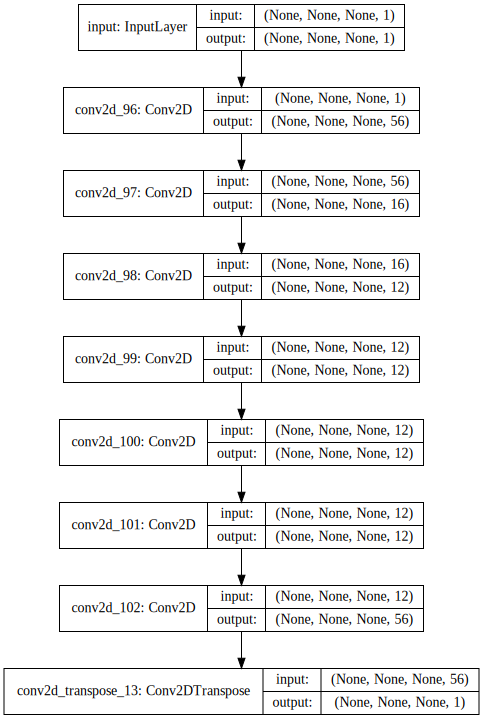

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
def prepare_training_data():
    names = os.listdir(DATA_PATH)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = DATA_PATH + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # produce Random_Crop random coordinate to crop training img
        if(min(shape[0], shape[1]) - label_size < 0):
            continue
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)

        for j in range(Random_Crop):
            hr_patch = hr_img[Points_x[j]: Points_x[j] + label_size, Points_y[j]: Points_y[j] + label_size]
            lr_patch = cv2.resize(hr_patch, (label_size // scale, label_size // scale), cv2.INTER_CUBIC)

            lr_patch = lr_patch.astype(float) // 255.
            hr_patch = hr_patch.astype(float) // 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch
            
    return data, label

In [0]:
def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)

In [0]:
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label
if __name__ == "__main__":
    data, label = prepare_training_data()
    write_hdf5(data, label, "traininingscale2.h5") #######################################GIVE THE NAME OF h5 FILE

In [0]:
def FSRCNN():
    _input = Input(shape=(None, None, 1), name='input')
    C1 = Conv2D(56,(5,5),padding='same', activation='relu')(_input)
    C2 = Conv2D(16,(1,1),padding='same', activation='relu')(C1)
    C3 = Conv2D(12,(3,3),padding='same', activation='relu')(C2)
    C4 = Conv2D(12,(3,3),padding='same', activation='relu')(C3)
    C5 = Conv2D(12,(3,3),padding='same', activation='relu')(C4)
    C6 = Conv2D(12,(3,3),padding='same', activation='relu')(C5)
    C7 = Conv2D(56,(1,1), padding='same', activation='relu')(C6)
    D1 = Conv2DTranspose(1,(9,9), strides=(2,2),padding='same', activation='relu')(C7)
    
    out = Conv2D(1,(1, 1),padding='same', activation='relu')(D1)
    model = Model(input=_input, output=out)
    return model

In [0]:
batch_size=128
nb_epoch=50

In [36]:
def FSRCNN_train():
    model = FSRCNN()
    model.compile(optimizer=adam(lr=0.0003), loss='mse')
    model.summary()
    data, label = pd.read_training_data("traininingscale2.h5")
    model.fit(data, label, batch_size=batch_size, nb_epoch=nb_epoch)
    model.save_weights("WAZIR_MODEL_SCALE_2.h5")


def model_predict():
    model = FSRCNN()
    model.load_weights("WAZIR_MODEL_SCALE_2.h5")
    IMG_NAME = "baby_GT.bmp"
    INPUT_NAME = "INPUT_LOW_RESOLUTION_IMAGE.bmp"
    OUTPUT_NAME = "MODEL_OUTPUT_IMAGE.bmp"

    import cv2
    img = cv2.imread(IMG_NAME)
    shape = img.shape
    img = cv2.resize(img, (shape[1] // 2, shape[0] // 2), cv2.INTER_CUBIC) ##############################
    cv2.imwrite(INPUT_NAME, img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1))
    Y[0, :, :, 0] = img[:, :, 0]
    img = cv2.resize(img, (shape[1], shape[0]), cv2.INTER_CUBIC)

    pre = model.predict(Y, batch_size=1)
    pre[pre[:] > 255] = 255
    pre = pre.astype(numpy.uint8)
    img[:, :, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)
    im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)
    im2 = cv2.resize(im2, (img.shape[1], img.shape[0]))
    im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)

    print ("Bicubic:")
    print (cv2.PSNR(im1, im2))
    print ("FSRCNN:")
    print (cv2.PSNR(im1, im3))


if __name__ == "__main__":
    FSRCNN_train()
    model_predict()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, None, 1)     0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, None, None, 56)    1456      
_________________________________________________________________
conv2d_120 (Conv2D)          (None, None, None, 16)    912       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, None, None, 12)    1740      
_________________________________________________________________
conv2d_122 (Conv2D)          (None, None, None, 12)    1308      
_________________________________________________________________
conv2d_123 (Conv2D)          (None, None, None, 12)    1308      
_________________________________________________________________
conv2d_124 (Conv2D)          (None, None, None, 12)    1308      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/50
12600/12600 [==============================] - 5s 413us/step - loss: 4.3960e-04
Epoch 2/50
12600/12600 [==============================] - 4s 291us/step - loss: 3.7172e-04
Epoch 3/50
12600/12600 [==============================] - 4s 290us/step - loss: 3.4730e-04
Epoch 4/50
12600/12600 [==============================] - 4s 291us/step - loss: 3.3137e-04
Epoch 5/50
12600/12600 [==============================] - 4s 292us/step - loss: 3.1815e-04
Epoch 6/50
12600/12600 [==============================] - 4s 291us/step - loss: 3.0763e-04
Epoch 7/50
12600/12600 [==============================] - 4s 290us/step - loss: 3.0044e-04
Epoch 8/50
12600/12600 [==============================] - 4s 292us/step - loss: 2.9709e-04
Epoch 9/50
12600/12600 [==============================] - 4s 292us/step - loss: 2.9277e-04
Epoch 10/50
12600/12600 [==============================] - 4s 291us/step - loss: 2.8915e-04
Epoch 11/50
12600/12600 [==============================] - 4s 290us/step - loss: 2.8554e-

In [0]:
GT_IMAGE = Image.open("baby_GT.bmp")############################################################
LR_IMAGE = Image.open("INPUT_LOW_RESOLUTION_IMAGE.bmp")
MODEL_IMAGE = Image.open("MODEL_OUTPUT_IMAGE.bmp")

(-0.5, 511.5, 511.5, -0.5)

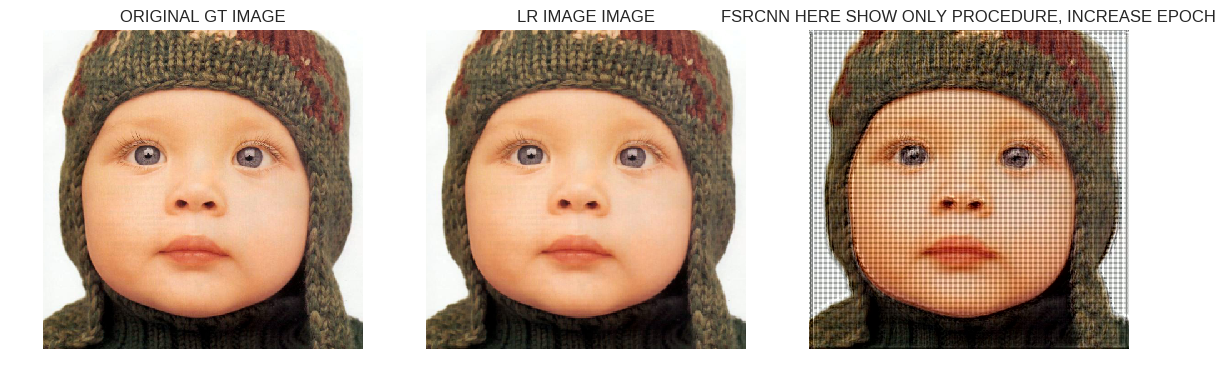

In [40]:
fig = plt.figure(figsize =(14,14),dpi=100)
ax = plt.subplot("131")
ax.imshow(GT_IMAGE)
ax.set_title('ORIGINAL GT IMAGE')
plt.axis('off')

ax = plt.subplot("132")
ax.imshow(LR_IMAGE)
ax.set_title('LR IMAGE IMAGE')
plt.axis('off')

ax = plt.subplot("133")
ax.imshow(MODEL_IMAGE)
ax.set_title('FSRCNN HERE SHOW ONLY PROCEDURE, INCREASE EPOCH')
plt.axis('off')